# Importing libraries

In [1]:
import pandas as pd
import numpy as np

import re
import pickle

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import string
from string import punctuation

import emoji

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from contractions import contractions_dict
from autocorrect import Speller

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\notco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\notco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\notco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


In [3]:
df = pd.read_csv("data/cyberbullying_tweets.csv")

In [4]:
df.head()

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

# Exploratory Data Analysis (EDA)

In [5]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [6]:
len(df)

47692

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [8]:
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)
df['cyberbullying_type'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

In [9]:
np.sum(df.isnull())

tweet_text            0
cyberbullying_type    0
dtype: int64

In [10]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'label'})

In [11]:
text, label = list(df['text']), list(df['label'])

In [12]:
df.sample(5)

text              label
42227  She wouldn’t even got the second nigger out i ...          ethnicity
10632  why do some people like to be so extra??? like...             gender
41200  DON’T!! it ain’t worth ur time sis i was force...          ethnicity
22309  #BringBackPayal @TwitterIndia u r vry soft on ...           religion
5839   RT @OnlyLookAtMino: [!!] #WINNER #ReallyReally...  not_cyberbullying

In [13]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

df['label_encoded'] = labelencoder.fit_transform(df['label'])

In [14]:
df[['label', 'label_encoded']].value_counts()

label              label_encoded
religion           4                7998
age                0                7992
gender             2                7973
ethnicity          1                7961
not_cyberbullying  3                7945
dtype: int64

# Data Cleaning

In [15]:
df['text'] = df['text'].str.lower()
df.tail()

text      label  \
47687  black ppl aren't expected to do anything, depe...  ethnicity   
47688  turner did not withhold his disappointment. tu...  ethnicity   
47689  i swear to god. this dumb nigger bitch. i have...  ethnicity   
47690  yea fuck you rt @therealexel: if youre a nigge...  ethnicity   
47691  bro. u gotta chill rt @chillshrammy: dog fuck ...  ethnicity   

       label_encoded  
47687              1  
47688              1  
47689              1  
47690              1  
47691              1

In [16]:
STOPWORDS = set(stopwords.words('english'))

In [17]:
df.sample(5)

text              label  \
8703   gay jokes are not funny to me at all &amp;neit...             gender   
34235  alex keeps sending me girls pictures and sayin...                age   
1579               stomach... why must you feel this way  not_cyberbullying   
14046  rt @__deesire__: "you mad bitch ?"ã°ââ¤â "st...             gender   
40283  fucking ugly ass fuck dumb fuck pussy ass nigg...          ethnicity   

       label_encoded  
8703               2  
34235              0  
1579               3  
14046              2  
40283              1

In [18]:
def contractions(text):
    expanded_words = []   
    for word in text.split():
        if word in contractions_dict:
            expanded_words.append(contractions_dict[word])
        else:
            expanded_words.append(word)
    return " ".join(expanded_words)

df['text'] = df['text'].apply(lambda text: contractions(text))

In [19]:
df.sample(5)

text              label  \
36538  i know a girl who bullied me from middle to hi...                age   
2868   rt @eleanortabone: #katandandre do you underst...  not_cyberbullying   
591    rt @hayatalvi: escaped syrian child soldier: '...  not_cyberbullying   
36419  my bully from high school just sent me a frien...                age   
34850  why does this remind me of the movies/tv shows...                age   

       label_encoded  
36538              0  
2868               3  
591                3  
36419              0  
34850              0

In [20]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [21]:
df.sample(5)

text              label  \
921                                                 #fat  not_cyberbullying   
45401  fuck haiti those dumb niggers expect to get ev...          ethnicity   
39436  thank you so much duane. 1 of the girls who bu...                age   
15790  trump likes to see the people he supposedly le...             gender   
12864  and as bad as rape jokes are they were also be...             gender   

       label_encoded  
921                3  
45401              1  
39436              0  
15790              2  
12864              2

In [22]:
def strip_emoji(text):
    return emoji.replace_emoji(text, replace='')

df['text'] = df['text'].apply(lambda text: strip_emoji(text))

In [23]:
df.sample(5)

text              label  \
8454   rt @marktrueblood: truth! a smart woman explai...             gender   
39573  at all ! s/o to the girls who were bullied and...                age   
6468   @haroonstyles @greenlinerzjm @halalflaws anoth...  not_cyberbullying   
17931  clapping !!!!! for idiots, when they said bad ...           religion   
42527  the black negro u called slave decades ago, ar...          ethnicity   

       label_encoded  
8454               2  
39573              0  
6468               3  
17931              4  
42527              1

In [24]:
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in STOPWORDS]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14)
    return text

df['text'] = df['text'].apply(lambda text: strip_all_entities(text))

In [25]:
df.sample(5)

text              label  \
7624   keep instant restaurant rounds people learn bl...  not_cyberbullying   
39631                          bet mom high school bully                age   
34651  got bullied group high school girls today know...                age   
273                                  hello birthday week  not_cyberbullying   
5669              2 cheats gave girls 1 chucked show mkr  not_cyberbullying   

       label_encoded  
7624               3  
39631              0  
34651              0  
273                3  
5669               3

In [26]:
def clean_hashtags(text):
    tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
    cleaned_tweet = " ".join(word.strip() for word in re.split('#|_', tweet))
    return cleaned_tweet

df['text'] = df['text'].apply(lambda text: clean_hashtags(text))

In [27]:
df.sample(5)

text     label  \
10707  mom talking brother would totally rape gay mid...    gender   
13188  sexes quit trying make demeaning names call us...    gender   
18135  lose lot pictures arabs muslims cancel followe...  religion   
10517                     might need lube tip wider hips    gender   
34694  im cackling bc someone said look like girls bu...       age   

       label_encoded  
10707              2  
13188              2  
18135              4  
10517              2  
34694              0

In [28]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

df['text'] = df['text'].apply(lambda text: remove_mult_spaces(text))

In [29]:
df.sample(5)

text     label  \
17389  fanbase beyond embarrassing times would though...  religion   
16997  um believe organization marxist antichristian ...  religion   
35452  bullied lot school mom strong always supported...       age   
18288  well investigated thousands white girls raped ...  religion   
23370  otherwise atheists support radical christians ...  religion   

       label_encoded  
17389              4  
16997              4  
35452              0  
18288              4  
23370              4

In [30]:
def clean_repeating_characters(text):
    return re.sub(r'(.)1+', r'1', text)

df['text'] = df['text'].apply(lambda text: clean_repeating_characters(text))

In [31]:
df.sample(5)

text              label  \
19902  wheras islam simply declared war humanity1400 ...           religion   
40069  obvious bullying innocent foreigners embracing...          ethnicity   
601                                      miss bestfriend  not_cyberbullying   
20148  total lie minorities muslim lands exterminated...           religion   
21636                     since muslims speak terrorists           religion   

       label_encoded  
19902              4  
40069              1  
601                3  
20148              4  
21636              4

In [32]:
def clean_numeric(text):
    return re.sub('[0-9]+', '', text)
    
df['text'] = df['text'].apply(lambda text: clean_numeric(text))

In [33]:
df.sample(5)

text      label  \
9920   stop making gay jokes stop making suicidal jok...     gender   
40961  racism u select ur white clothes wash first b ...  ethnicity   
10382  mkr thing funnier upside ice cream maker inser...     gender   
23347  chart stupid rss hindutwaa idiots think india ...   religion   
9061                                                idea     gender   

       label_encoded  
9920               2  
40961              1  
10382              2  
23347              4  
9061               2

In [34]:
df["text"].duplicated().sum()

1033

In [35]:
df.drop_duplicates("text", inplace=True)

In [36]:
df[['label', 'label_encoded']].value_counts()

label              label_encoded
religion           4                7946
age                0                7894
ethnicity          1                7743
not_cyberbullying  3                7641
gender             2                7612
dtype: int64

In [37]:
text_len = []
for text in df.text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [38]:
df['text_len'] = text_len

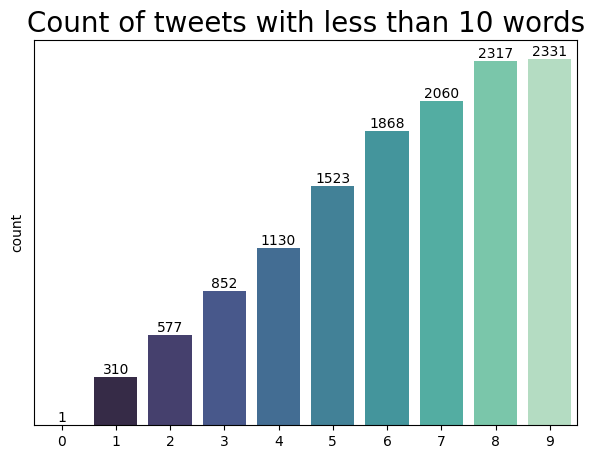

In [39]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [40]:
df.sort_values(by=['text_len'], ascending=False)

text              label  \
44035  black white trying live like nigger pahahahaha...          ethnicity   
45165  fuck obama dumb ass nigger bitch ltthis whore ...          ethnicity   
1317   researchers push import top antibullying progr...  not_cyberbullying   
33724  feel guilty killing feel guilty enjoyed tormen...                age   
47037  sooo mad rt fuck obama dumb nigger im going sw...          ethnicity   
...                                                  ...                ...   
8087                                            feminazi             gender   
12772                                            bitches             gender   
14555                                          feminazis             gender   
3679                                                  ah  not_cyberbullying   
10                                                        not_cyberbullying   

       label_encoded  text_len  
44035              1       182  
45165              1       156  
1317               3       139  
33724              0       134  
47037              1       123  
...              ...       ...  
8087               2         1  
12772              2         1  
14555              2         1  
3679               3         1  
10                 3         0  

[38836 rows x 4 columns]

In [41]:
df = df[df['text_len'] > 3]
df = df[df['text_len'] < 100]

In [42]:
df

text              label  \
0                words katandandre food crapilicious mkr  not_cyberbullying   
1      aussietv white mkr theblock today sunrise stud...  not_cyberbullying   
2                       classy whore red velvet cupcakes  not_cyberbullying   
3      meh p thanks heads concerned another angry dud...  not_cyberbullying   
4      isis account pretending kurdish account like i...  not_cyberbullying   
...                                                  ...                ...   
47687  black ppl expected anything depended anything ...          ethnicity   
47688  turner withhold turner called court abominable...          ethnicity   
47689  swear god dumb nigger bitch got bleach hair re...          ethnicity   
47690  yea fuck rt youre nigger fucking unfollow fuck...          ethnicity   
47691  bro u got chill rt dog fuck kp dumb nigger bit...          ethnicity   

       label_encoded  text_len  
0                  3         5  
1                  3        10  
2                  3         5  
3                  3         9  
4                  3         8  
...              ...       ...  
47687              1        21  
47688              1        28  
47689              1        13  
47690              1        10  
47691              1        12  

[37087 rows x 4 columns]

In [43]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)

In [44]:
st = nltk.PorterStemmer()

def text_stemming(text):
    text = [st.stem(word) for word in text]
    return text

df['text'] = df['text'].apply(lambda text: text_stemming(text))

In [45]:
lm = nltk.WordNetLemmatizer()

def text_lemmatization(text):
    text = [lm.lemmatize(word) for word in text]
    return text

df['text'] = df['text'].apply(lambda text: text_lemmatization(text))

In [46]:
df.sample(5)['text']

5241     [e, una, limpieza, sabia, aunqu, el, bulli, se...
18680    [dear, son, u, actual, knw, wt, hindutva, mean...
21557    [straight, cathol, christian, woman, believ, l...
37164    [luca, ive, bulli, whole, life, school, partic...
5886                [stupid, articl, devoid, fact, reason]
Name: text, dtype: object

# WordCloud

In [47]:
wc_0_df = df
wc_0_df = wc_0_df[wc_0_df['label'] != 'not_cyberbullying']
wc_0_df = wc_0_df['text'].apply(lambda x: " ".join(x))

In [48]:
wc_0_df.sample(5)

35792    oh caus thought girl bulli high school brillo ...
20216                    object pc moron salon call racism
13298    joke dck dont take hard islam race religion cr...
44747    dumb as realli fix fuck whole futur cuz want c...
32042    agre tweet derogatori thing toward peopl ampgr...
Name: text, dtype: object

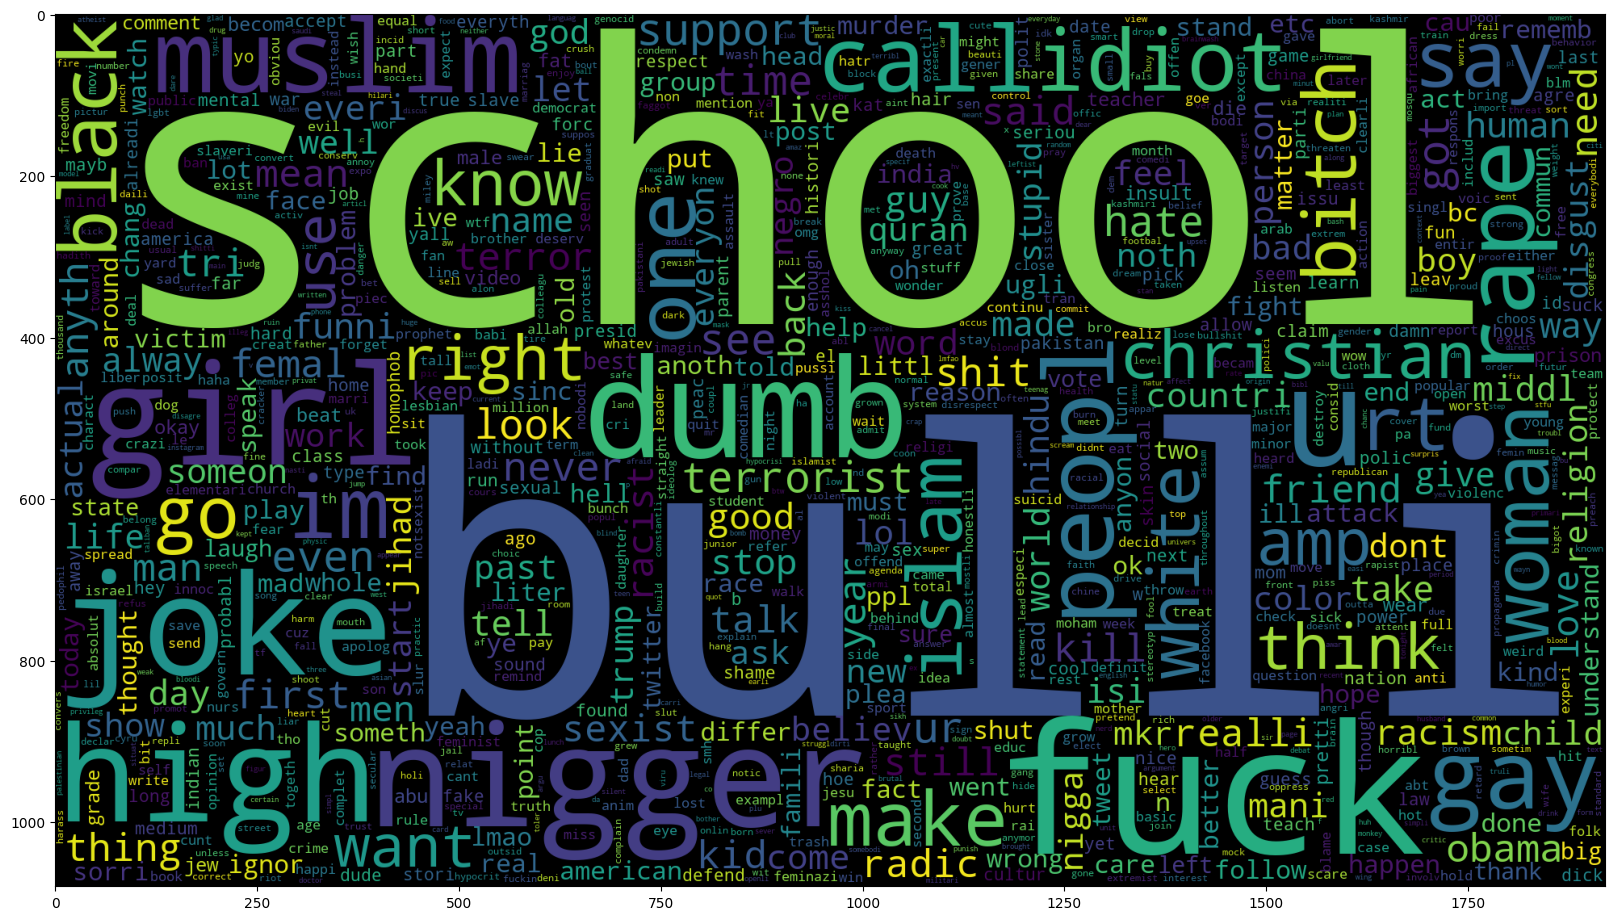

In [49]:
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=1000, width= 1920, height= 1080, 
                collocations= False).generate(' '.join(wc_0_df))
plt.imshow(wc)

In [50]:
wc_1_df = pd.read_csv("data/cyberbullying_tweets.csv")
wc_1_df = wc_1_df[wc_1_df['cyberbullying_type'] != "not_cyberbullying"]
wc_1_df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

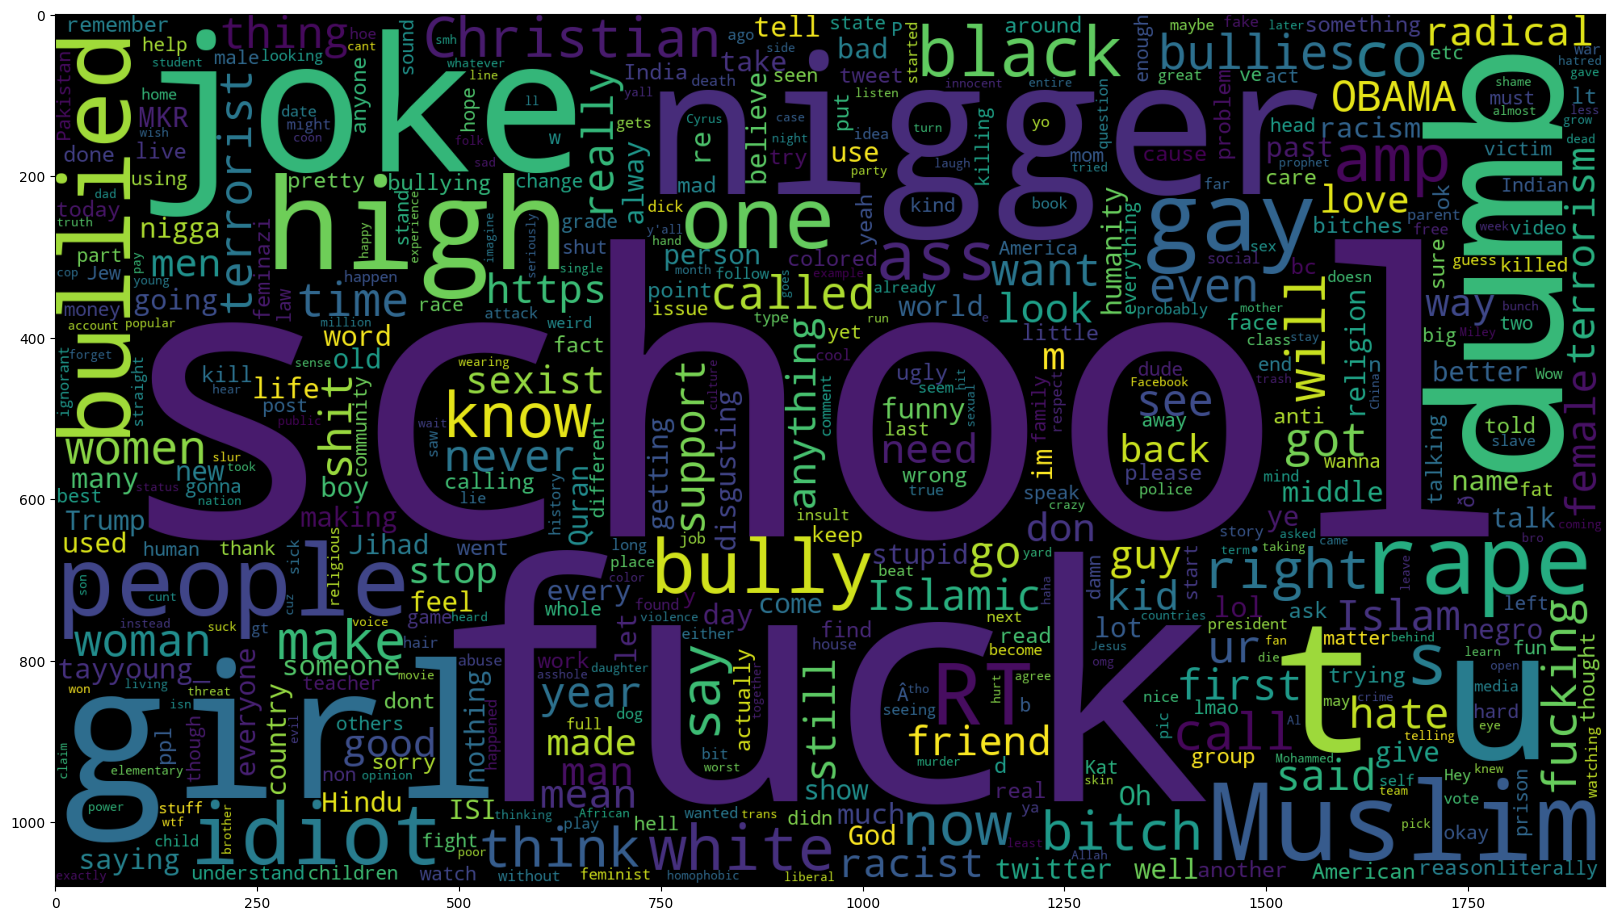

In [51]:
plotting_data = wc_1_df['tweet_text']
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=500, width= 1920, height= 1080, 
                collocations= False).generate(' '.join(plotting_data))
plt.imshow(wc)

In [52]:
wc_2_df = wc_1_df[wc_1_df['cyberbullying_type'] != "not_cyberbullying"]
wc_2_df = wc_1_df[wc_1_df['cyberbullying_type'] != "other_cyberbullying"]
wc_2_df['cyberbullying_type'].value_counts()

religion     7998
age          7992
gender       7973
ethnicity    7961
Name: cyberbullying_type, dtype: int64

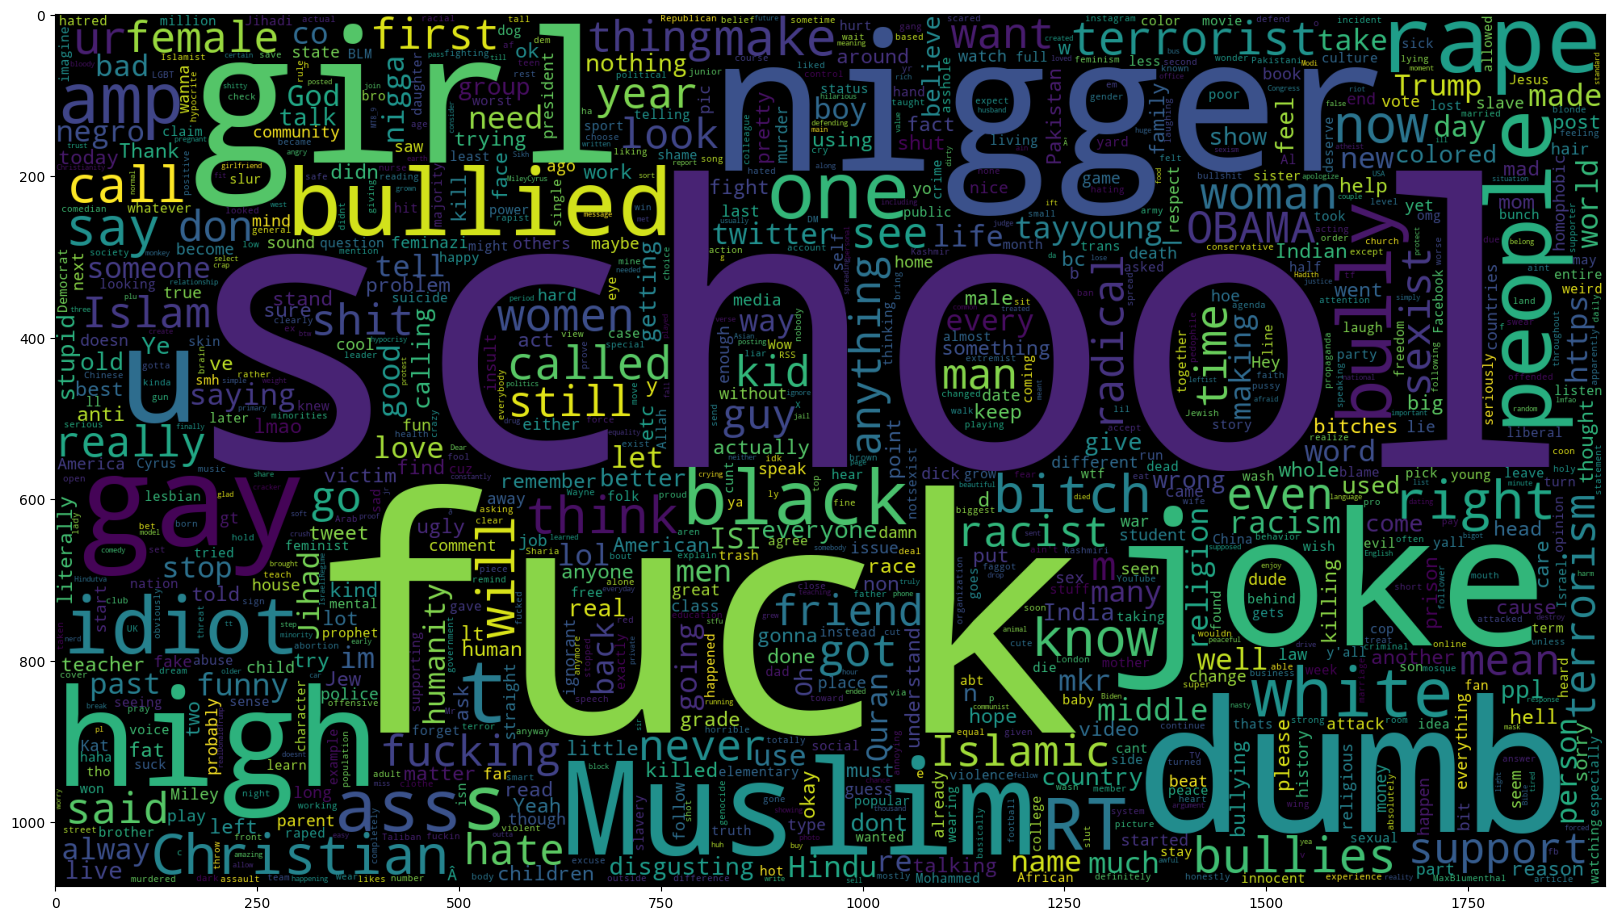

In [53]:
plotting_data = wc_2_df['tweet_text']
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=1000, width= 1920, height= 1080, 
                collocations= False).generate(' '.join(plotting_data))
plt.imshow(wc)

In [54]:
df.sample(5)

text      label  \
22825  [damn, good, conserv, christian, woman, right,...   religion   
41381  [much, ob, color, race, made, contribut, inclu...  ethnicity   
36445          [look, like, would, bulli, middl, school]        age   
36884  [feel, like, savag, hack, account, mf, school,...        age   
43996  [let, ask, someth, greek, call, white, peopl, ...  ethnicity   

       label_encoded  text_len  
22825              4        20  
41381              1        25  
36445              0         6  
36884              0        18  
43996              1        14

# Model Creation

In [55]:
df['text'] = df['text'].apply(lambda x : " ".join(x))

In [63]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features= 500000)

tf_transformer = tfidf.fit(df['text'])
X_tf = tf_transformer.transform(df['text'])

In [64]:
X_tf

<37087x325214 sparse matrix of type '<class 'numpy.float64'>'
	with 988261 stored elements in Compressed Sparse Row format>

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_tf, df['label'], test_size=0.20, stratify=df['label'], random_state=42)

In [68]:
y_train.value_counts()

religion             6311
age                  6269
ethnicity            6161
gender               5842
not_cyberbullying    5086
Name: label, dtype: int64

In [69]:
from imblearn.over_sampling import SMOTE
vc = y_train.value_counts()
while (vc[0] != vc[4]) or (vc[0] !=  vc[2]) or (vc[0] !=  vc[3]) or (vc[0] !=  vc[1]):
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    vc = y_train.value_counts()

y_train.value_counts()

ethnicity            6311
age                  6311
not_cyberbullying    6311
religion             6311
gender               6311
Name: label, dtype: int64

## Model Training

### SVM

In [70]:
svm_clf = SVC(kernel= 'linear', C = 1)
svm_clf.fit(X_train, y_train)

SVC(C=1, kernel='linear')

### Naive Bayes

In [71]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

### K Nearest Neighbor

In [72]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

### Random Forest

In [73]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

## Model Evaluation

### SVM

In [74]:
svm_predictions  = svm_clf.predict(X_test)
print(classification_report(y_test, svm_predictions))

                   precision    recall  f1-score   support

              age       0.97      0.98      0.97      1567
        ethnicity       0.98      0.98      0.98      1541
           gender       0.95      0.87      0.91      1461
not_cyberbullying       0.79      0.87      0.83      1271
         religion       0.96      0.95      0.95      1578

         accuracy                           0.93      7418
        macro avg       0.93      0.93      0.93      7418
     weighted avg       0.93      0.93      0.93      7418



In [75]:
svm_cv_score = cross_val_score(svm_clf,X_train, y_train, cv=3)
print('Cross validation score: ', svm_cv_score.mean())

Cross validation score:  0.9331010411937126


### Naive Bayes

In [76]:
nb_predictions = nb_clf.predict(X_test)
print(classification_report(y_test, nb_predictions))

                   precision    recall  f1-score   support

              age       0.83      0.99      0.90      1567
        ethnicity       0.91      0.95      0.93      1541
           gender       0.90      0.87      0.88      1461
not_cyberbullying       0.87      0.48      0.62      1271
         religion       0.84      0.98      0.90      1578

         accuracy                           0.87      7418
        macro avg       0.87      0.85      0.85      7418
     weighted avg       0.87      0.87      0.85      7418



In [77]:
nb_cv_score = cross_val_score(nb_clf,X_train, y_train, cv=3)
print('Cross validation score: ', nb_cv_score.mean())

Cross validation score:  0.8755190785529011


### K Nearest Neighbor

In [78]:
knn_pred = knn_clf.predict(X_test)
print(classification_report(y_test, knn_pred))

                   precision    recall  f1-score   support

              age       0.98      0.50      0.66      1567
        ethnicity       0.97      0.76      0.86      1541
           gender       0.91      0.77      0.83      1461
not_cyberbullying       0.29      0.95      0.45      1271
         religion       0.97      0.04      0.07      1578

         accuracy                           0.59      7418
        macro avg       0.82      0.60      0.57      7418
     weighted avg       0.84      0.59      0.57      7418



In [79]:
knn_cv_score = cross_val_score(knn_clf,X_train, y_train, cv=3)
print('Cross validation score: ', knn_cv_score.mean())

Cross validation score:  0.68087726671374


### Random Forest

In [80]:
rf_pred = rf_clf.predict(X_test)
print(classification_report(y_test, rf_pred))

                   precision    recall  f1-score   support

              age       0.98      0.98      0.98      1567
        ethnicity       0.99      0.98      0.99      1541
           gender       0.96      0.85      0.90      1461
not_cyberbullying       0.79      0.90      0.84      1271
         religion       0.96      0.96      0.96      1578

         accuracy                           0.94      7418
        macro avg       0.94      0.93      0.93      7418
     weighted avg       0.94      0.94      0.94      7418



In [81]:
rf_cv_score = cross_val_score(rf_clf,X_train, y_train, cv=3)
print('Cross validation score: ', rf_cv_score.mean())

Cross validation score:  0.936079886543522


## Saving trained models

In [82]:
pickle.dump(svm_clf,open('data/svm_clf.pkl','wb'))
pickle.dump(nb_clf,open('data/nb_clf.pkl','wb'))
pickle.dump(knn_clf,open('data/knn_clf.pkl','wb'))
pickle.dump(rf_clf,open('data/rf_clf.pkl','wb'))

## Saving vectoriser

In [66]:
pickle.dump(tf_transformer,open('data/vectorizer.pkl','wb'))

## Testing

In [65]:
test = np.zeros(100)
test = ["shut the fuck up you bitch ass nigger don't talk to me.",]
test = tfidf.transform(test)
test

<1x325214 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>